In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import , train_test_split
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier

import optuna
from functools import partial
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('training.zip')
test_df = pd.read_csv('test.zip')

In [4]:
from sklearn.preprocessing import LabelEncoder,normalize,MinMaxScaler
LE = LabelEncoder()

train_df['Label'] = LE.fit_transform(train_df['Label'])
train_df.head()

In [107]:
X_train = train_df.drop(['EventId', 'Weight','Label'], axis=1)
y_train = train_df.Label

In [112]:
def objective(trial, X, y, name='higgs'):
        
    params = {'max_depth':trial.suggest_int('max_depth', 5, 50),
              'n_estimators':200000,
              'subsample': trial.suggest_uniform('subsample', 0.2, 1.0),
              'colsample_bytree':trial.suggest_uniform('colsample_bytree', 0.2, 1.0),
              'learning_rate':trial.suggest_uniform('learning_rate', 0.007, 0.02),
              'reg_lambda':trial.suggest_uniform('reg_lambda', 0.01, 50),
              'reg_alpha':trial.suggest_uniform('reg_alpha', 0.01, 50),
              'min_child_samples':trial.suggest_int('min_child_samples', 5, 100),
              'num_leaves':trial.suggest_int('num_leaves', 10, 200),
              'n_jobs' : -1,
              'metric':'binary_logloss',
              'max_bin':trial.suggest_int('max_bin', 300, 1000),
              'cat_smooth':trial.suggest_int('cat_smooth', 5, 100),
              'cat_l2':trial.suggest_loguniform('cat_l2', 1e-3, 100)}

    model = LGBMClassifier(objective="binary", **params)
                  
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
              eval_metric=['binary_logloss'],
              early_stopping_rounds=300, 
              #callbacks=[optuna.integration.LightGBMPruningCallback(trial, metric='rmse')],
              verbose=1)

                  
    return log_loss(y_val,model.predict(X_val))

In [113]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial,X=X_train, y=y_train)
study.optimize(func, n_trials=20)

In [114]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [151]:
# This is taken from the printed values in previous cell 
lgbm_params = { 'max_depth': 9,
    'subsample': 0.7730780498269871,
    'colsample_bytree': 0.6387676696977731,
    'learning_rate': 0.0123564377640701,
    'reg_lambda': 46.29907650439835,
    'reg_alpha': 16.959124157211022,
    'min_child_samples': 7,
    'num_leaves': 115,
    'max_bin': 523,
    'cat_smooth': 49,
    'cat_l2': 30.182489403995866}

In [152]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [153]:
model = LGBMClassifier(objective="binary", **lgbm_params,n_estimators=10000)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)],eval_metric=['binary_logloss'],early_stopping_rounds=300, verbose=1)

In [1]:
X_test = test_df.drop(['EventId'], axis=1)

In [2]:
pred = model.predict(X_test)
pred

In [6]:
inv_y_test = LE.inverse_transform(pred)
inv_y_test

In [7]:
subm=pd.read_csv("random_submission.zip")
subm.head(2)

In [3]:
subm.Class = inv_y_test

In [4]:
subm['RankOrder'] = subm['Class'].argsort().argsort() + 1 

In [5]:
subm.to_csv("higgssubm4.csv",index=False)

This is evaluated on AMS and got 2.9 in private and 2.8 in public

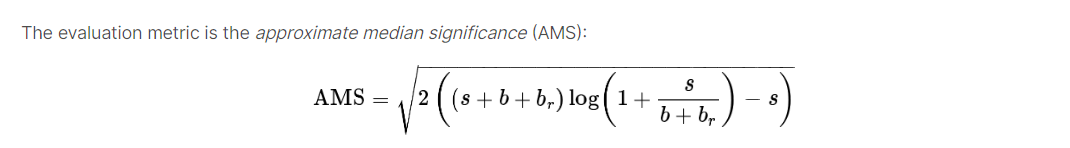